This note book demonstrates how to apply KDRO to the uncertain least squares problem in the paper. Simply run all the cells.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from kdro.lsq_util import *

## Prepare parameters for the problem

In [3]:
dim_x = 10 # dim of decision var
dim_w = 1 # dim for the uncertain var \xi
n_sample = 10 # how many empirical samples \hat{xi} to use
epsilon = 0.1 # epsilon in the kdro problem
n_certify = 50 # how many zeta to sample. cf. paper
n_run = 10 # independent runs

## Solve uncertain lsq. using KDRO

In [4]:
res_dro=[]
for j in range(n_run):
    # load data for the optimization problem
    datafile = pickle.load(open('data/robls.bin', 'rb'))['6.15']  # data set from boyd vandenberghe text    
    data_emp, A, b, B = dataGengenerate(datafile, dim_x, dim_w, 10, n_sample) # create data
    lsq = costFun(method='boyd', model=[A, B, b], mode='cvxpy') # loss function

    # run KDRO
    theta_kdro, obj, apy, y0, kernel_gamma, loc_py = kDroPy(lsq, data_emp, epsilon=epsilon,
                                                      dim_x=dim_x, n_certify=n_certify,
                                                      sampling_method='bound')

    res = {'data_emp': data_emp, 'thpy': theta_kdro, 'apy': apy, 'y0sol': y0, 'epsilon': epsilon, 'A0': A,
           'B': B, 'b': b, 'loc_py': loc_py, 'kernel_gamma': kernel_gamma,
           'n_certify': n_certify, 'obj': obj
           }
    
#     ### CVaR variant; if you wish to use the unconstrained CVaR formulation in the paper
    # alpha = 0.01
    # res = kDroCvar(lsq, data_emp, epsilon=epsilon, dim_x=dim_x, n_certify=n_certify, chance_level=alpha)
    # res = {'data_emp': data_emp, 'thpy': res['x'], 'apy': res['a'] ,'y0sol': res['cvar'], 'epsilon': epsilon, 'A0': A,
    #                'B': B, 'b': b, 'loc_py':res['location_certify'], 'kernel_gamma': res['kernel_gamma'],
    #                'n_certify': n_certify, 'obj':res['obj'], 'chance_level':alpha
    #            }

    res_dro.append(res)

## Test the K-DRO solution $\theta$

In [5]:
# create some test data whose distribution shiftedd from that used for obtaining theta
n_test = 500 # number of test samples

disturb_set = np.linspace(0.0,5.0, 50)
data_test = []
for dd in disturb_set:
    data_test.append((1+dd)* np.random.uniform(-0.5, 0.5, size=[n_test, dim_w]))

In [6]:
# this cell tests the KDRO sollution on the created test data set 
RES = [] 
for D in res_dro:
    # making new scenarios for plots
    A, B, b, x_dro, kernel_gamma, y0 = D['A0'], D['B'], D['b'], D['thpy'],D['kernel_gamma'], D['y0sol']
    obj_rkhs = D['obj']
    a = D['apy']
    data_emp = D['data_emp']
    location_expansion = D['loc_py']

    eps=D['epsilon']

    # function used to evaluate the lsq cost
    cost_toy = costFun(method='boyd', model=[np.asarray(A), np.asarray(B), np.asarray(b)], mode='numpy')

    # run thru test set
    mus = [] # track all mean cost
    sigmas = [] # all std

    for shift in data_test:
        cost_test = []
        for s in shift:
            cost_test.append(cost_toy.eval(x_dro, s)) # test the kdro solution by evaluating the lsq cost

        mu = np.mean(cost_test)
        sigma = np.std(cost_test)
        mus.append(mu)
        sigmas.append(sigma)

        all_data = np.concatenate([data_emp,shift])
        kernel_width, kernel_gamma = median_heuristic(all_data, all_data)

        w1 = np.ones_like(data_emp)/data_emp.shape[0]
        w2 = np.ones_like(shift)/shift.shape[0]

    ### bookkeeping, store all data useful for plots
    RES.append({'eps':eps, 'mu':mus, 'sig':sigmas, 'disturbance':disturb_set, 
               'x_dro':x_dro, 'obj_rkhs':obj_rkhs})

# bookkeeping
RES_DRO = []
mmmm = [r['mu'] for r in RES]
mu_all = np.mean(mmmm, axis=0)
sig_all = np.std(mmmm, axis=0)
RES_DRO.append({'eps':eps, 'mu':mu_all, 'sig':sig_all, 'x_dro':x_dro})

## Comparison with other methods
We compare KDRO with the following:
- sample average approximation (SAA), a.k.a., empirical risk minimization (ERM)
- worst-case RO based on SDP

In [7]:
mus_wc=[]
mus_nom=[]

WC_ALL=[]
NOM_ALL=[]
for D in res_dro:
    A, B, b, x_dro, kernel_gamma, y0 = D['A0'], D['B'], D['b'], D['thpy'],D['kernel_gamma'], D['y0sol']
    loc_certify = D['loc_py'] # all certified samples zeta during DRO
    
    data_emp = D['data_emp']
    dim_x = x_dro.shape[0]

    # classic RO
    x_wc, _ = robustLs(A, B, b)
    x_nom=saa(data_emp, A, B, b, dim_x)
    
    costs_wc=[]
    costs_nom=[]

    for shift in data_test:
        cost_wc = []
        cost_nom = []

        for s in shift:
            cost_wc.append(cost_toy.eval(x_wc, s))
            cost_nom.append(cost_toy.eval(x_nom, s))

        costs_wc.append(np.mean(cost_wc))
        costs_nom.append(np.mean(cost_nom))
        
    
    WC_ALL.append(costs_wc)
    NOM_ALL.append(costs_nom)
    
# convert into np
WC_ALL = np.asarray([c for c in WC_ALL])
NOM_ALL = np.asarray([c for c in NOM_ALL])

RES_COMP={
    'mu_wc': np.mean(WC_ALL,axis=0),
    'mu_nom': np.mean(NOM_ALL,axis=0),
    'sig_wc': np.std(WC_ALL,axis=0),
    'sig_nom': np.std(NOM_ALL,axis=0),
}

## Plot the test comparisons of the above solutions

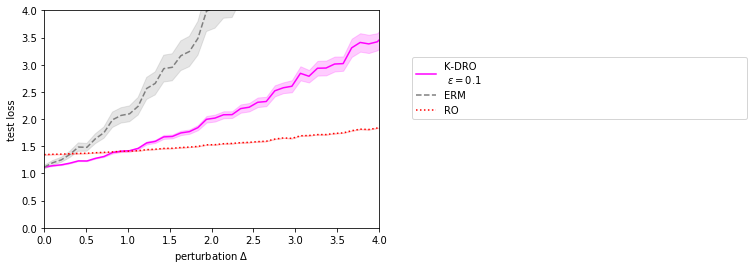

In [8]:
plt.figure()
ax_main = plt.gca()

clrs=[ 'magenta','blue', 'green', 'yellow', 'red', 'orange']
iclr=0

for r in RES_DRO:
    dict_kw = {
        'mu': r['mu'],
        'sig': r['sig'],
        'disturb_set': disturb_set,
        'n_run': n_run,
        'color': clrs[iclr],
        'ax_main': ax_main,
        'label': 'K-DRO\n $\epsilon=$' + str(r['eps']),
        'linestyle': '-'
    }
    kdroPlot(**dict_kw)
    plt.xlabel('perturbation $\Delta$')
    plt.ylabel('test loss')
    iclr += 1
    
# competing methods
r = RES_COMP

# ERM
dict_kw =  {
        'mu':r['mu_nom'],
        'sig':r['sig_nom'],
        'disturb_set':disturb_set,
        'n_run':n_run,
        'color': 'gray',
        'ax_main': ax_main,
        'label': 'ERM',
        'linestyle': '--'
    }
kdroPlot(**dict_kw )

# RO
dict_kw =  {
        'mu':r['mu_wc'],
        'sig':r['sig_wc'],
        'disturb_set':disturb_set,
        'n_run':n_run,
        'color': 'red',
        'ax_main': ax_main,
        'label': 'RO',
        'linestyle': ':'
    }
kdroPlot(**dict_kw )

plt.legend(loc=(1.1, 0.5), ncol=1, mode="expand", borderaxespad=0.)
plt.xlim([0, 4.0])
plt.ylim([0, 4.0])
plt.show()